<a href="https://colab.research.google.com/github/Thien2213255/AI-projects/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/QuananhNguyen-04/TimeSeriesStock.git

Cloning into 'TimeSeriesStock'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 50 (delta 5), reused 44 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (50/50), 2.53 MiB | 7.82 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
!pip install vnstock3
from vnstock3 import Vnstock



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 18.9 MB/s eta 0:00:00

    Khi tiếp tục sử dụng Vnstock3, bạn xác nhận rằng bạn đã đọc, hiểu và đồng ý với Chính sách quyền riêng tư và Điều khoản, điều kiện về giấy phép sử dụng Vnstock3.

    Chi tiết:

    - Giấy phép sử dụng phần mềm: https://vnstocks.com/docs/tai-lieu/giay-phep-su-dung
    - Chính sách quyền riêng tư: https://vnstocks.com/docs/tai-lieu/chinh-sach-quyen-rieng-tu
    


In [ ]:
torch.manual_seed(25)

In [ ]:
# df=pd.read_csv('/content/TimeSeriesStock/data/BID.csv')
# print(df.info())
# df

# # Set the '<DTYYYYMMDD>' column as the index
# df = df.set_index('<DTYYYYMMDD>')
# # Delete the '<Ticker>' column
# del df['<Ticker>']
# del df['<Volume>']
# df

In [ ]:
company = "BID"
stock = Vnstock().stock(symbol=company, source='VCI')
df = stock.quote.history(start='2014-01-01', end='2024-06-21', interval='1D')
df

2024-12-08 10:22:26 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


,time,open,high,low,close,volume
0,2014-01-24,9.96,10.22,9.70,9.85,8417060
1,2014-01-27,9.80,9.85,9.49,9.65,3240910
2,2014-02-06,9.54,9.59,9.23,9.23,959590
3,2014-02-07,9.12,9.17,8.65,8.70,2987600
4,2014-02-10,8.65,9.02,8.49,8.91,4052090
...,...,...,...,...,...,...
2590,2024-06-17,47.50,47.50,46.50,46.50,2815727
2591,2024-06-18,46.70,47.05,46.50,46.50,1470307
2592,2024-06-19,46.80,46.80,45.85,46.10,2602167
2593,2024-06-20,46.00,46.20,45.35,45.50,2673823


 use vnstock uncomment below

In [ ]:
company = "BID"
stock = Vnstock().stock(symbol=company, source='VCI')
df = stock.quote.history(start='2014-01-01', end='2024-06-21', interval='1D')
datatime = pd.to_datetime(df["time"])
df["year"] = datatime.dt.year
df["month"] = datatime.dt.month
df["day"] = datatime.dt.day
df = df.set_index('time')
df = df.drop(['year', 'month', 'day', 'volume'], axis=1)
data = {}
data[company] = torch.tensor(df.values)


2024-12-08 11:25:52 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [ ]:
data[company]

tensor([[ 9.9600, 10.2200,  9.7000,  9.8500],
        [ 9.8000,  9.8500,  9.4900,  9.6500],
        [ 9.5400,  9.5900,  9.2300,  9.2300],
        ...,
        [46.8000, 46.8000, 45.8500, 46.1000],
        [46.0000, 46.2000, 45.3500, 45.5000],
        [45.6000, 46.4500, 45.5500, 45.6000]], dtype=torch.float64)

In [ ]:
# prompt: Using dataframe df: scale the data  with min max scaler

# from sklearn.preprocessing import MinMaxScaler

# # Create a MinMaxScaler object
# scaler = MinMaxScaler()

# # Select numerical columns to scale (excluding the date column)
# numerical_cols = ['open','high','low','close','volume']

# # Fit the scaler to the data and transform the numerical columns
# df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
# df

In [ ]:
X = data[company][:]

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data: torch.Tensor, seq_len):
        print(data.shape)
        self.scaler = 24
        self.X = data[:, :] / 24 # All sequences, except the last element, all features
        self.Y = data[:, 3] / 24  # All sequences, only the last element, Close feature
        self.seq_len = seq_len
        self.lagging = 0

    def __len__(self):
        return len(self.X) - self.seq_len - self.lagging

    def __getitem__(self, idx):
        if idx < 0:
            idx = self.__len__() + idx

        return {
            'seq': self.X[idx: idx + self.seq_len],
            'label': self.Y[idx + self.seq_len + self.lagging]
        }

In [ ]:
test_ratio = 0.9
split_index = int(len(data[company]) * test_ratio)

train_d, test_d = data[company][:split_index], data[company][split_index:]

In [ ]:
split_index = int(len(X) * 0.9)
print(split_index)
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

2335


(torch.Size([2335, 4]),
 torch.Size([260, 4]),
 torch.Size([1595, 1]),
 torch.Size([0, 1]))

In [ ]:
# Create datasets
def create_dataset(seq_len):
  train_dataset = MyDataset(train_d, seq_len)
  test_dataset = MyDataset(test_d, seq_len)

  # Create DataLoaders
  batch_size = 64  # Adjust as needed
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  for batch in train_loader:
      seq = batch["seq"]
      label = batch["label"]

      print("Sequence shape:", seq.shape)
      print("Label shape:", label.shape)
      break
  return train_dataset, test_dataset, train_loader, test_loader

In [ ]:

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super(Model, self).__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
        )
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # self.fci = nn.Linear(seq_len * hidden_dim, 8)
        self.fc = nn.Linear(hidden_dim, 1)
        # self.relu = nn.ReLU()

        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                # Input-to-hidden weights: Xavier Uniform Initialization
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                # Hidden-to-hidden weights: Orthogonal Initialization
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)
    def forward(self, x):
        if self.lstm.batch_first is True:
            h0 = torch.zeros(
                self.num_layers, x.size(0), self.hidden_dim
            ).to(x.device)
            c0 = torch.zeros(
                self.num_layers, x.size(0), self.hidden_dim
            ).to(x.device)

        out, _ = self.lstm(x, (h0,c0))

        out = self.fc(out)
        out = out.squeeze(-1)

        return out

In [ ]:
def calculate_mape(y_true, y_pred):
    """
    Calculates the Mean Absolute Percentage Error (MAPE).

    Args:
        y_true: The actual values.
        y_pred: The predicted values.

    Returns:
        The MAPE value.
    """

    # Convert to NumPy arrays if necessary
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # print (f"cal acc with true = {y_true} and pred = {y_pred}")
    # Avoid division by zero
    mask = y_true != 0

    # Calculate MAPE
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    return mape

In [ ]:
def train_one_epoch(LSTM):
    LSTM.train(True)

    running_loss = 0
    running_accuracy = 0.0
    for batch_idx, batch in enumerate(train_loader):
        inputs = batch['seq'].to(device).type(torch.float32)  # Move to device
        labels = batch['label'].to(device).type(torch.float32)   # Move to device


        optimizer.zero_grad()
        outputs = LSTM(inputs)

        outputs = outputs[:,-1]
        acc = calculate_mape(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy())
        running_accuracy += acc
        rmse_loss = torch.sqrt(criterion(outputs, labels.type(torch.float32)))
        running_loss += rmse_loss.item()
        rmse_loss.backward()
        optimizer.step()

In [ ]:

def validate_one_epoch(LSTM):
    LSTM.eval()
    running_loss = 0.0
    running_acc = 0.0
    total_samples = 0

    for batch_idx, batch in enumerate(test_loader):
        inputs = batch['seq'].to(device).type(torch.float32)  # Move to device
        labels = batch['label'].to(device).type(torch.float32)   # Move to device

        with torch.no_grad():
            outputs = LSTM(inputs)  # Shape: [batch_size, 1] (assuming single output)
            outputs = outputs[:,-1]
            rmse_loss = torch.sqrt(criterion(outputs, labels))
            running_loss +=  rmse_loss.item()
            running_acc += calculate_mape(labels.cpu().detach().numpy(), outputs.cpu().detach().numpy()) * len(labels)
            total_samples += len(labels)
    avg_mse = running_loss / total_samples
    avg_mape = running_acc / total_samples
    return avg_mse, avg_mape

# Training

In [ ]:
num_epochs = 200
def training(save_test_loss, mape_loss, model):
  for epoch in tqdm(range(num_epochs), desc="Traning Epochs"):

    train_one_epoch(model)
    avg_rmse, avg_mape = validate_one_epoch(model)
    mape_loss.append(avg_mape)
    save_test_loss.append(avg_rmse)

  print(min(mape_loss), min(save_test_loss))


In [ ]:
# prompt: from save_test_loss, plot it
def plot_loss(save_test_loss, title):
  save_test_loss = [avg_loss for avg_loss in save_test_loss]
  # Assuming 'save_test_loss' is a list containing the test loss values from each epoch
  plt.plot(save_test_loss)
  plt.xlabel("Epoch")
  plt.ylabel("Test Loss")
  plt.title(f"Test Loss vs. Epoch, {title}")
  plt.grid(True)
  plt.show()

In [ ]:
def plot_mape(mape_loss, title):
  mape_loss = [avg_mape for avg_mape in mape_loss]
  # Assuming 'save_test_loss' is a list containing the test loss values from each epoch
  plt.plot(mape_loss)
  plt.xlabel("Epoch")
  plt.ylabel("MAPE Loss")
  plt.title(f"MAPE Loss vs. Epoch, {title}")
  plt.grid(True)
  plt.show()

In [ ]:
# prompt: use model to predict all dataset and plot it
def simulate(RNN):
  eval_dataset = DataLoader(test_dataset, batch_size=1, shuffle=False)
  RNN.eval()
  with torch.inference_mode():
      predictions = []
      actual_values = []
      for i, batch in enumerate(eval_dataset):
          input = batch['seq'].to(device).type(torch.float32)
          truth = batch['label'].to(device).type(torch.float32)
          out = RNN(input)
          predictions.append((out[0, -1] * test_dataset.scaler).cpu().numpy())
          actual_values.append((truth[0] * test_dataset.scaler).cpu().numpy())

  print(len(predictions))
  print(len(actual_values))


  # Plot the predictions against the actual values
  plt.figure(figsize=(15, 6))
  plt.plot(actual_values, label="Actual Values")
  plt.plot(predictions, label="Predictions")
  plt.xlabel("Time Steps")
  plt.ylabel("Value")
  plt.title("Predictions vs. Actual Values")
  plt.legend()
  plt.show()


## Training with sequence length = 50

In [ ]:
train_dataset, test_dataset, train_loader, test_loader = create_dataset(50)

torch.Size([2335, 4])
torch.Size([260, 4])
Sequence shape: torch.Size([64, 50, 4])
Label shape: torch.Size([64])


In [ ]:
save_test_loss_50 = []
mape_loss_50 = []

In [ ]:
LSTM_50 = Model(input_dim=4, hidden_dim=5, num_layers=1)
LSTM_50.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(LSTM_50.parameters(), lr=0.01)

In [ ]:
training(save_test_loss_50, mape_loss_50, LSTM_50)

Traning Epochs: 100%|██████████| 200/200 [00:25<00:00,  7.97it/s]

2.6397276563303813 0.0010655002757197335


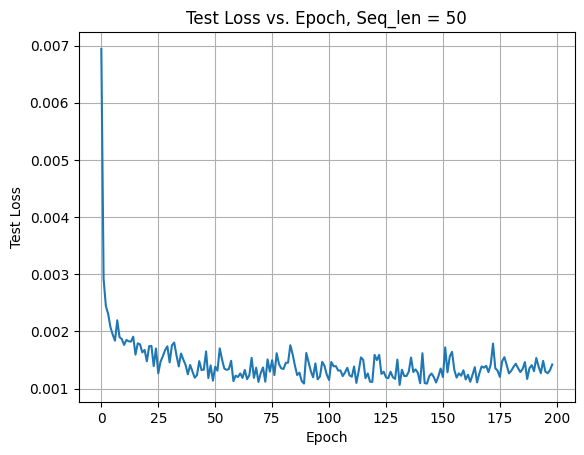

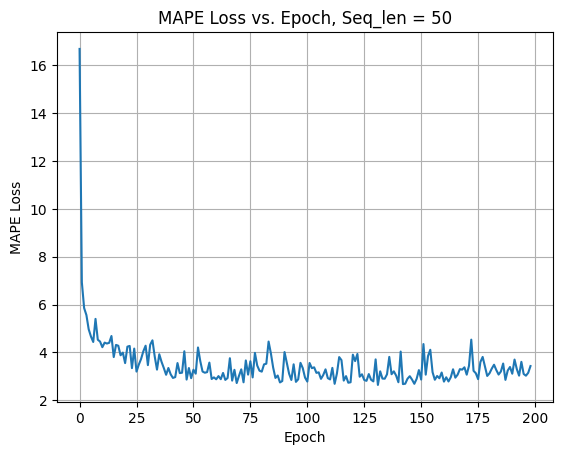

210
210


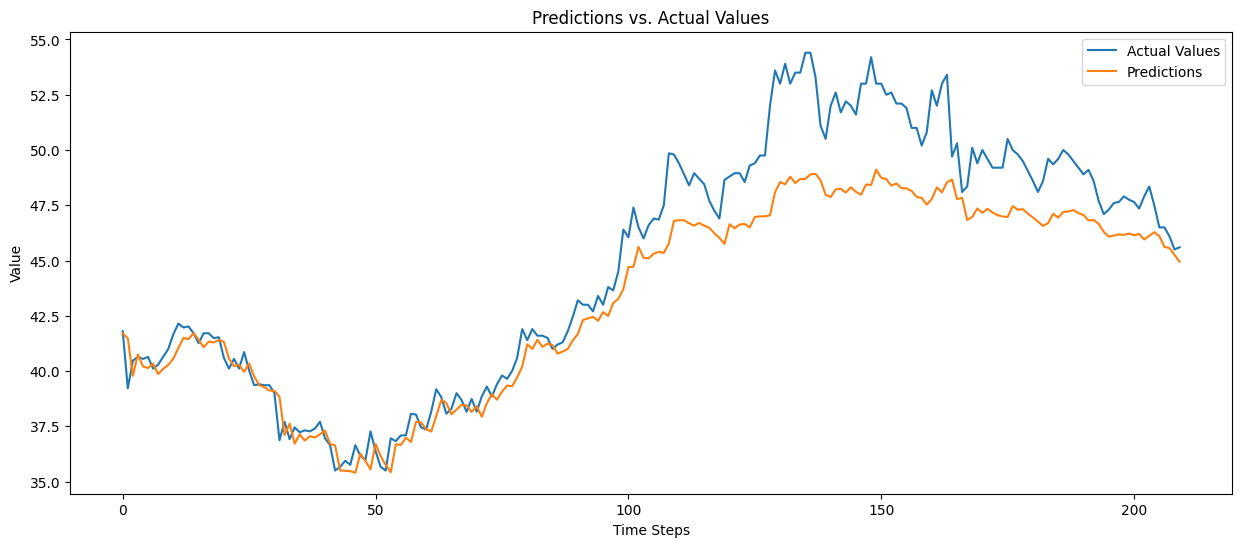

In [ ]:
plot_loss(save_test_loss_50[1:], "Seq_len = 50")
plot_mape(mape_loss_50[1:], "Seq_len = 50")
simulate(LSTM_50)

## Training with sequence length = 100

In [ ]:
train_dataset, test_dataset, train_loader, test_loader = create_dataset(100)

torch.Size([2335, 4])
torch.Size([260, 4])
Sequence shape: torch.Size([64, 100, 4])
Label shape: torch.Size([64])


In [ ]:
save_test_loss_100 = []
mape_loss_100 = []

In [ ]:
LSTM_100 = Model(input_dim=4, hidden_dim=5, num_layers=1)
LSTM_100.to(device)
# prompt: Initialize the device, model, criterion, and optimizer

criterion = nn.MSELoss() # call mse in pytorch , but since torch dont have RMSE i will sqroot it later
optimizer = optim.Adam(LSTM_100.parameters(), lr=0.01)

In [ ]:
training(save_test_loss_100, mape_loss_100, LSTM_100)

Traning Epochs: 100%|██████████| 200/200 [00:26<00:00,  7.45it/s]

1.800164133310318 0.0007906724000349641


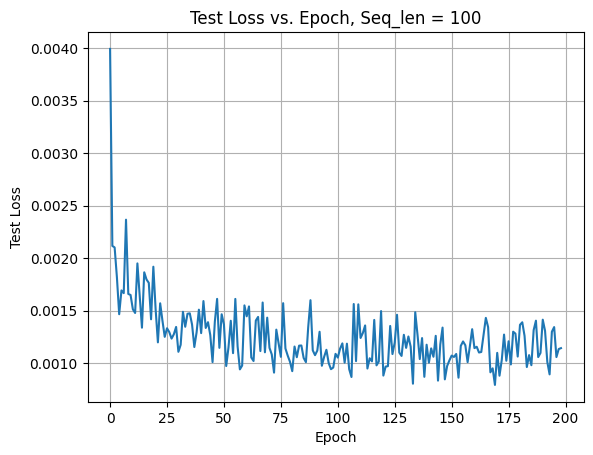

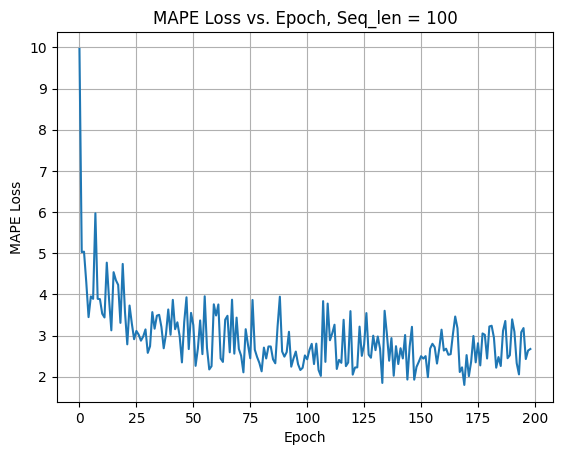

160
160


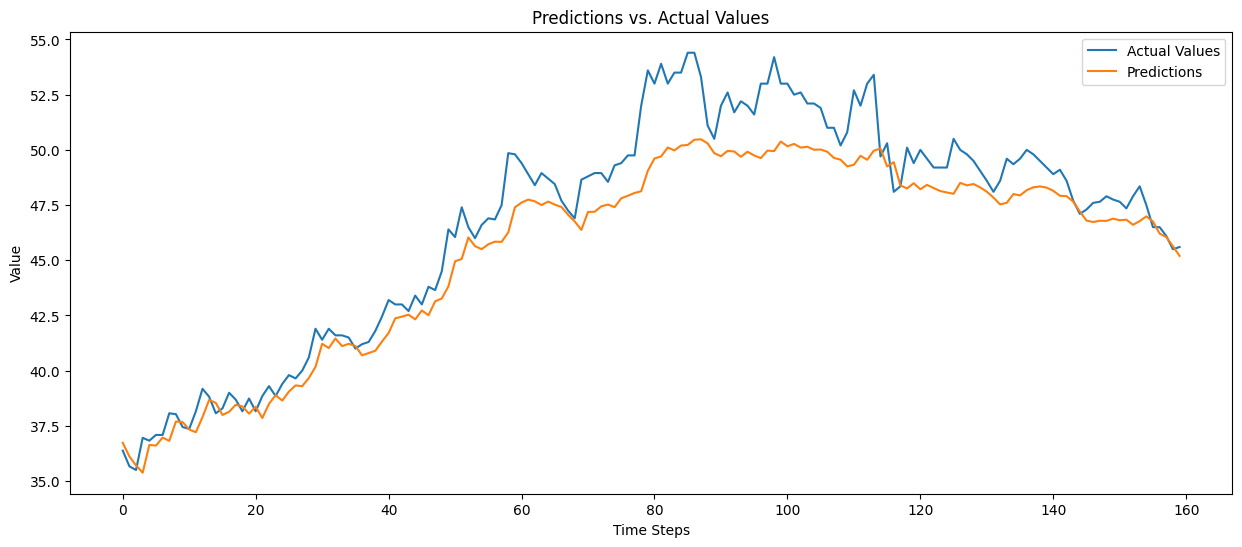

In [ ]:
plot_loss(save_test_loss_100[1:], "Seq_len = 100")
plot_mape(mape_loss_100[1:], "Seq_len = 100")
simulate(LSTM_100)

## Training with sequence length = 10

In [ ]:
train_dataset, test_dataset, train_loader, test_loader = create_dataset(10)

torch.Size([2335, 4])
torch.Size([260, 4])
Sequence shape: torch.Size([64, 10, 4])
Label shape: torch.Size([64])


In [ ]:
save_test_loss_10 = []
mape_loss_10 =  []

In [ ]:
LSTM_10 = Model(input_dim=4, hidden_dim=5, num_layers=1)
LSTM_10.to(device)
# prompt: Initialize the device, model, criterion, and optimizer

criterion = nn.MSELoss() # call mse in pytorch , but since torch dont have RMSE i will sqroot it later
optimizer = optim.Adam(LSTM_10.parameters(), lr=0.01)

In [ ]:
training(save_test_loss_10, mape_loss_10 , LSTM_10)

Traning Epochs: 100%|██████████| 200/200 [00:27<00:00,  7.36it/s]

1.6084598042070866 0.0006445507556200028


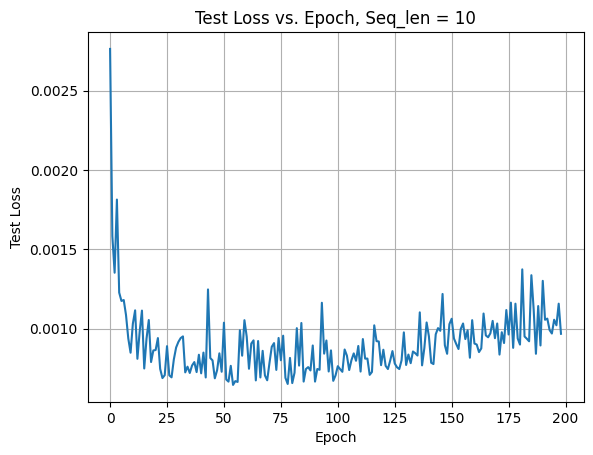

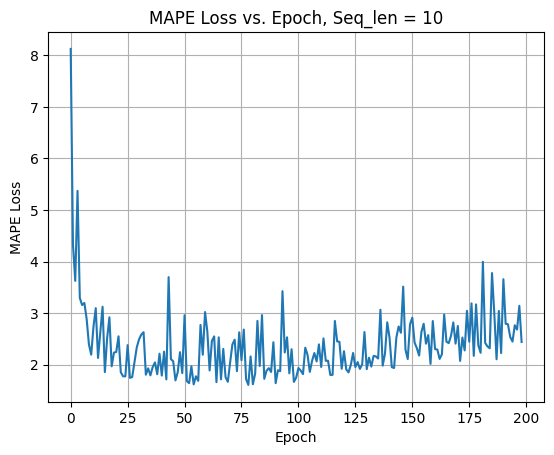

250
250


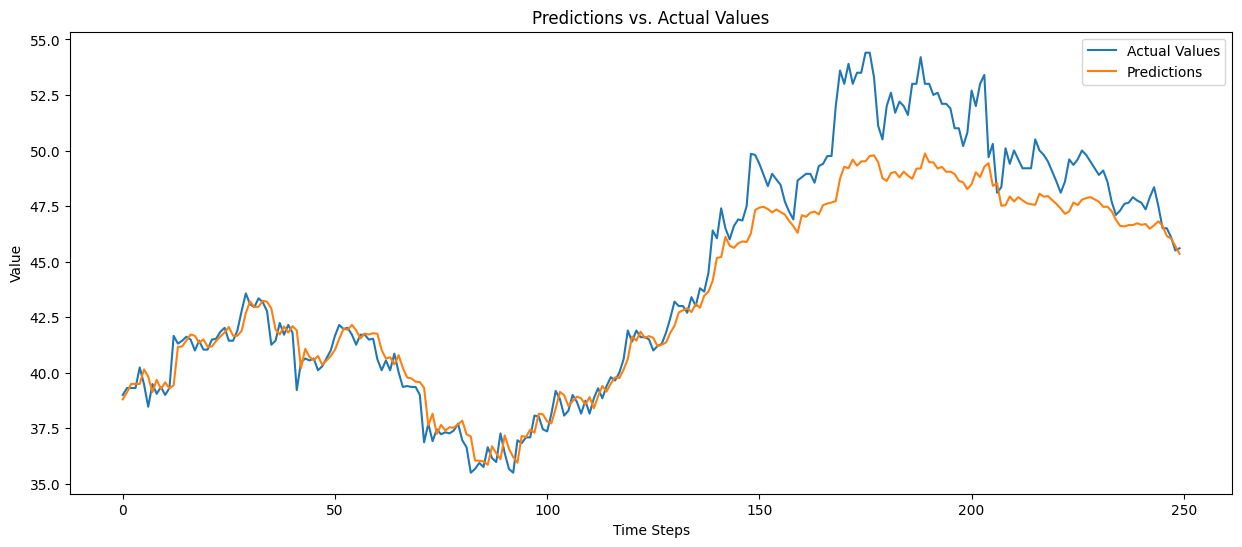

In [ ]:
plot_loss(save_test_loss_10[1:], "Seq_len = 10")
plot_mape(mape_loss_10[1:], "Seq_len = 10")
simulate(LSTM_10)

## Training with sequence length = 20

In [ ]:
train_dataset, test_dataset, train_loader, test_loader = create_dataset(20)

torch.Size([2335, 4])
torch.Size([260, 4])
Sequence shape: torch.Size([64, 20, 4])
Label shape: torch.Size([64])


In [ ]:
save_test_loss_20 = []
mape_loss_20 = []

In [ ]:
LSTM_20 = Model(input_dim=4, hidden_dim=5, num_layers=1)
LSTM_20.to(device)
# prompt: Initialize the device, model, criterion, and optimizer

criterion = nn.MSELoss() # call mse in pytorch , but since torch dont have RMSE i will sqroot it later
optimizer = optim.Adam(LSTM_20.parameters(), lr=0.01)

In [ ]:
training(save_test_loss_20, mape_loss_20, LSTM_20)

Traning Epochs: 100%|██████████| 200/200 [00:26<00:00,  7.68it/s]

1.732210988799731 0.0007071385548139612


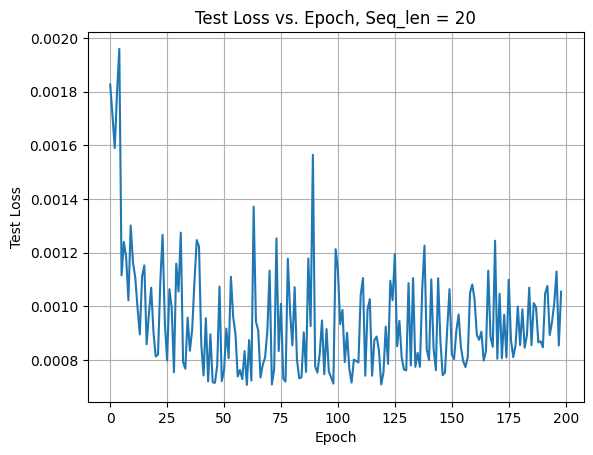

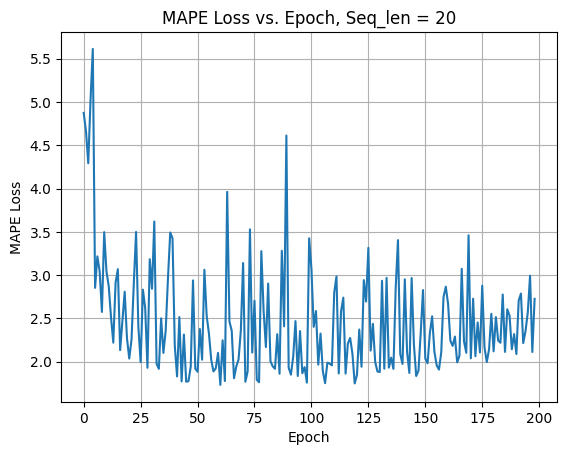

240
240


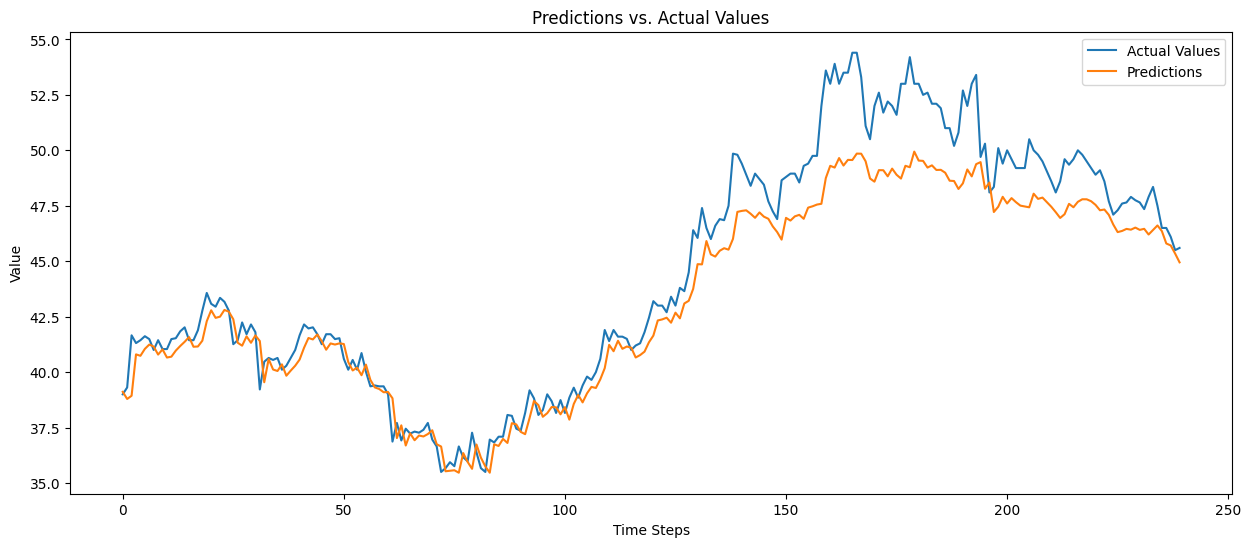

In [ ]:
plot_loss(save_test_loss_20[1:], "Seq_len = 20")
plot_mape(mape_loss_20[1:], "Seq_len = 20")
simulate(LSTM_20)

# Debug, view inside

In [ ]:
# prompt: printing every parameters in model
for i, layer in enumerate(LSTM.modules()):
       print(f"Layer {i}: {layer}")
for name, param in LSTM.named_parameters():
  print(f"Parameter Name: {name}")
  print(f"Parameter Shape: {param.shape}")
  print(f"Parameter Data: {param}")
  print("-" * 30)